In [227]:
import pandas as pd
import numpy as np
import json
import math
from statistics import mode
from sklearn.metrics import ndcg_score, f1_score, average_precision_score

In [2]:
metadata_url = "https://mikeanders.org/data/CMS/CMS-2018-0101-0001/CMS-1701-P%20Comment%20MetaData.csv"
data = pd.read_csv(metadata_url, usecols=range(0,36))[:469] #ignore last few columns and blank rows at end of csv 
data = data.rename(columns=lambda x: x.strip()) #strip whitespace from columns

In [3]:
data10 = data.fillna(0) #fill NaN with 0

In [4]:
section_cols = data10.columns[3:] 
data10[section_cols] = data10[section_cols].replace(["Y"], 1) #replace Y with 1 in approriate columns

In [5]:
section_cols


Index(['A2', 'A3', 'A4b', 'A4c', 'A5b', 'A5c', 'A5d', 'A6b', 'A6b.1', 'A6c',
       'A6d2', 'A6d3', 'A7', 'A7.1', 'A7.2', 'B2a', 'B2b', 'C2', 'C3a', 'C3b',
       'C3b.1', 'D2', 'D3b', 'D3c', 'D3d', 'D4', 'E2', 'E3', 'E4', 'E5', 'E6',
       'E7', 'F'],
      dtype='object')

In [6]:
data11 = data10.copy()

In [7]:
section_cols1  = data11.columns[3:] 

In [8]:
data11[section_cols1] = np.where((data11[section_cols1]  != 1),0,data11[section_cols1] )
data11

,Name,Organization Name / Submitter name,Submitter State,A2,A3,A4b,A4c,A5b,A5c,A5d,...,D3c,D3d,D4,E2,E3,E4,E5,E6,E7,F
0,CMS-2018-0101-DRAFT-0002-08_23_2018-05_17_PM,Erick Meleher,NC,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,CMS-2018-0101-DRAFT-0003-08_23_2018-05_18_PM,Mayank Shah,IL,0,0,0,0,0,0,0,...,1,0,0,0,0,0,1,0,0,0
2,CMS-2018-0101-DRAFT-0004-08_24_2018-01_16_PM,Mayank Shah,IL,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,CMS-2018-0101-DRAFT-0005-08_29_2018-10_05_AM,Morey Menacker,NJ,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
4,CMS-2018-0101-DRAFT-0006-08_30_2018-09_14_AM,Todd Rapoza,MA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
464,CMS-2018-0101-DRAFT-0466-10_17_2018-04_53_AM,Liberty ACO,TX,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
465,CMS-2018-0101-DRAFT-0467-10_17_2018-04_53_AM,Washington State Hospital Association,WA,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
466,CMS-2018-0101-DRAFT-0468-10_17_2018-05_02_AM,Think Whole Person Healthcare,NE,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
467,CMS-2018-0101-DRAFT-0469-10_17_2018-05_02_AM,Palm Beach Accountable Care Organization,FL,0,1,0,1,1,1,0,...,1,0,0,0,1,1,0,1,0,0


In [9]:
# Combining columns for index matching: (A6b, A6b.1, = A6b),  (C3b, C3b.1'= C3b) ('A7', 'A7.1', 'A7.2', = A7b, a7c),  (F = F2, F3)

data11['A6b'] = (data11['A6b'] + data11['A6b.1'])
data11['A6b'] = data11['A6b'].replace(2,1)
data11['A6b'].value_counts()

0    448
1     21
Name: A6b, dtype: int64

In [10]:
data11['C3b'] = (data11['C3b'] + data11['C3b.1'])
data11['C3b'] = data11['C3b'].replace(2,1)
data11['C3b'].value_counts()

0    413
1     56
Name: C3b, dtype: int64

In [11]:
data11['A7'] = (data11['A7'] + data11['A7.1'] + data11['A7.2'])
data11['A7'] = data11['A7'].replace(2,1)
data11['A7'] = data11['A7'].replace(3,1)
data11['A7'].value_counts()

0    418
1     51
Name: A7, dtype: int64

In [12]:
data11 = data11.drop(['A6b.1', 'C3b.1', 'A7.1', 'A7.2'], axis = 1)

In [165]:
section_cols1  = data11.columns[3:]
section_cols1

Index(['A2', 'A3', 'A4b', 'A4c', 'A5b', 'A5c', 'A5d', 'A6b', 'A6c', 'A6d2',
       'A6d3', 'A7', 'B2a', 'B2b', 'C2', 'C3a', 'C3b', 'D2', 'D3b', 'D3c',
       'D3d', 'D4', 'E2', 'E3', 'E4', 'E5', 'E6', 'E7', 'F'],
      dtype='object')

In [14]:
truth_dict = {} # initiate dict
for i, name in enumerate(data11.Name): # iterate through Comment Names
    dict1 = {col:data11[col].iloc[i] for col in section_cols1} # locate this row's values for each column
    list1 = [key.lower() for key,value in dict1.items() if value==1] # create list of matching sections for this row
    name1 = str(name).split('DRAFT-')[1].split('-')[0] # format Comment Name
    truth_dict[name1] = list1 # add Comment Name and list of matching sections to dict

In [15]:
#truth_dict

In [16]:
num_matches = {key: len(value) for key, value in truth_dict.items()}
mode(list(num_matches.values()))

1

In [166]:
#define true rule section names
truth_keys = list(section_cols1)
truth_keys = [key1.lower() for key1 in truth_keys]

In [250]:
short_ones = {'0083': 'good luck everyone!',
 '0142': 'see attached file(s)',
 '0237': 'see attached file(s)\n',
 '0270': 'see attached file(s)\n',
 '0293': 'see attached file(s)',
 '0321': 'see attached file(s)\n\n',
 '0324': 'see attachement\n',
 '0329': 'see attached file(s)\n',
 '0342': 'see attached file(s)\n',
 '0447': 'see attached file(s)'}

In [264]:
{key: truth_dict[key] for key in list(short_ones.keys())}
{key: value for key, value in truth_dict.items() if not value}

{'0083': [],
 '0110': [],
 '0126': [],
 '0240': [],
 '0256': [],
 '0259': [],
 '0287': [],
 '0318': [],
 '0378': [],
 '0380': [],
 '0384': [],
 '0392': [],
 '0408': [],
 '0436': [],
 '0449': [],
 '0456': [],
 '0457': [],
 '0460': [],
 '0467': []}

## Header Index Testing

In [76]:
with open('header_results.json') as f:
    header_results_json = json.load(f)

In [78]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in header_results_json.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx and true_key not in value_list: 
                value_list.append(true_key)
        header_results_json[key]=value_list     

In [81]:
# match_dict shows all true positives, without penalty to false categorization
match_dict= {}
for (key1, value1), (key2,value2) in zip(truth_dict.items(), header_results_json.items()):
    match_count = 0
    for val_idx in value1:
        if val_idx in value2:
            match_count += 1
        match_dict[key1]=match_count/len(value1)

In [82]:
# unpenalized accuracy of true positives
meanvals = np.mean(list(match_dict.values()))
meanvals

0.6912193145919602

In [83]:
# match_dict1 shows all true positives, with penalty to false categorization
match_dict1= {}
for (key1, value1), (key2,value2) in zip(truth_dict.items(), header_results_json.items()):
    match_count = 0
    for val_idx in value2:
        if val_idx in value1:
            match_count += 1
        match_dict1[key1]=match_count/len(value2)

In [84]:
# penalized accuracy of true positives
meanvals1 = np.mean(list(match_dict1.values()))
meanvals1

0.1964311206281228

In [85]:
np.mean([meanvals,meanvals1])

0.44382521761004146

### Sklearn NDCG Headers

In [317]:
#create truth dict with values equal to sparse array length=29, binary
truth_dict_all = truth_dict.copy()
for key, value in truth_dict.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    truth_dict_all[key] = new_value_list

In [318]:
#create header results dict with values equal to sparse array length=29, binary
binary_header_results_all = header_results_json.copy()
for key, value in header_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    counter = 1
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                counter += 1
                new_value_list[i] = 1
    binary_header_results_all[key] = new_value_list

In [319]:
#create header results dict with values equal to sparse array length=29, (discounted)
header_results_all = header_results_json.copy()
for key, value in header_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    counter = 1
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                counter += 1
                new_value_list[i] = 1/math.log(counter, 2)
    header_results_all[key] = new_value_list

In [349]:
headers_ndcg = {}
headers_ap = {}
headers_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), header_results_all.items()):
    headers_ndcg[true_key] = ndcg_score([true_value], [es_value])
    headers_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), binary_header_results_all.items()):
    headers_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [350]:
np.mean(list(headers_ndcg.values()))

0.49903416408593465

In [351]:
np.mean(list(headers_ap.values()))

0.8570332116550786

In [352]:
np.mean(list(headers_f1.values()))

0.7728176929773714

## Hybrid Index Testing

In [353]:
with open('hybrid_results.json') as f1:
    hybrid_results_json = json.load(f1)

In [354]:
#tranlate ES keys to true rule section names, MAINTAINING ORDER
for key, value in hybrid_results_json.items():
    value_list = []
    for val_idx in value:
        for true_key in truth_keys:
            if true_key in val_idx[0:4] and true_key not in value_list:
                    value_list.append(true_key)
        hybrid_results_json[key]=value_list            

In [355]:
# match_dict shows all true positives, without penalty to false categorization
match_dict= {}
for (key1, value1), (key2, value2) in zip(truth_dict.items(), hybrid_results_json.items()):
    match_count = 0
    for val_idx in value1:
            if val_idx in value2:
                match_count += 1
            match_dict[key1]=match_count/len(value1)

In [356]:
# unpenalized accuracy of true positives
meanvals = np.mean(list(match_dict.values()))
meanvals

0.5976229564346515

In [357]:
# match_dict1 shows all true positives, with penalty to false categorization
match_dict1= {}
for (key1, value1), (key2,value2) in zip(truth_dict.items(), hybrid_results_json.items()):
    match_count = 0
    for val_idx in value2:
        if val_idx in value1:
            match_count += 1
        match_dict1[key1]=match_count/len(value2)

In [358]:
# penalized accuracy of true positives
meanvals1 = np.mean(list(match_dict1.values()))
meanvals1

0.2820714795554196

In [359]:
np.mean([meanvals,meanvals1])

0.43984721799503557

### SKlearn NDCG Hybrid

In [370]:
#create header results dict with values equal to sparse array length=29, binary
binary_hybrid_results_all = hybrid_results_json.copy()
for key, value in hybrid_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                new_value_list[i] = 1
    binary_hybrid_results_all[key] = new_value_list

In [371]:
#create header results dict with values equal to sparse array length=29, binary (discounted)
hybrid_results_all = hybrid_results_json.copy()
for key, value in hybrid_results_json.items():
    new_value_list = np.zeros(len(truth_keys))
    counter = 1
    for val in value:
        for i in range(len(truth_keys)):
            if val == truth_keys[i]:
                counter += 1
                new_value_list[i] = 1/math.log(counter, 2)
    hybrid_results_all[key] = new_value_list

In [394]:
hybrid_ndcg = {}
hybrid_ap = {}
hybrid_f1 = {}
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), hybrid_results_all.items()):
    hybrid_ndcg[true_key] = ndcg_score([true_value], [es_value])
    hybrid_ap[true_key] = average_precision_score(true_value, es_value, pos_label=0)
for (true_key, true_value), (es_key, es_value) in zip(truth_dict_all.items(), binary_hybrid_results_all.items()):
    hybrid_f1[true_key] = f1_score(true_value, es_value, zero_division=0, pos_label=0)

In [391]:
np.mean(list(hybrid_ndcg.values()))

0.5378007301359915

In [392]:
np.mean(list(hybrid_ap.values()))

0.8624696149333047

In [393]:
np.mean(list(hybrid_f1.values()))

0.30928868858575326

### NDCG

In [377]:
def Cummulative_gain(truth, pred):
    counter = 0
    for i in truth:
        if i in pred:
            counter +=1
    return counter
def Discounted_Cummulative_gain(truth, pred):
    DCG = 0
    for i,j in enumerate(pred):
        if j in truth:
            DCG += (1/(math.log(i+2,2)))
    return DCG
def Ideal_discounted_cummulative_gain(truth, pred):
    counter = 0
    IDCG = 0
    for i in truth:
        if i in pred:
            counter +=1
    for i in range(counter):
        IDCG += (1/(math.log(i+2,2)))
    return IDCG
def nDiscounted_Cummulative_gain(truth, pred):
    x = Ideal_discounted_cummulative_gain(truth, pred)
    y = Discounted_Cummulative_gain(truth, pred)
    return y/(x+0.0001)

## Average Precision

In [378]:
def average_precision(truth, pred):
    runn = 0
    cum_gain = 0
    for i, j in enumerate(truth):
        if j in pred:
            cum_gain +=1
            runn = runn + cum_gain/(i+1)
    average_pred = runn / (cum_gain + 0.0001)
    return average_pred

## F1 Score

In [379]:
def F_1_score(truth, pred):
    AP = average_precision(truth, pred)
    F_1 = AP/(AP + 1)
    return 2*F_1

## Headers Scoring

In [380]:
CG = {}
DCG = {}
iDCG = {}
nDCG = {}
AP = {}
F_1 = {}
MAP = 0
count = 0
for (i,(k,j)) in zip(truth_dict.values(),header_results_json.items()):
    CG[k] = Cummulative_gain(i,j)
    DCG[k] = Discounted_Cummulative_gain(i,j)
    iDCG[k] = Ideal_discounted_cummulative_gain(i,j)
    nDCG[k] = nDiscounted_Cummulative_gain(i,j)
    AP[k] = average_precision(i,j)
    F_1[k] = F_1_score(i,j)
    count +=1
    MAP +=AP[k]
Model_eval = pd.DataFrame(data=[CG, DCG, iDCG, nDCG, AP, F_1])
MAP/count

0.8606288207724131

In [381]:
Model_eval = Model_eval.transpose().rename({0:'CG',1:'DCG',2:'iDCG',3:'nDCG',4:'AP',5:'F1'}, axis=1)
Model_eval

,CG,DCG,iDCG,nDCG,AP,F1
0002,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
0003,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
0004,1.0,0.356207,1.00000,0.356172,0.999900,0.999950
0005,1.0,0.500000,1.00000,0.499950,0.999900,0.999950
0006,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
0465,3.0,1.286884,2.13093,0.603879,0.999967,0.999983
0466,1.0,0.500000,1.00000,0.499950,0.999900,0.999950
0467,0.0,0.000000,0.00000,0.000000,0.000000,0.000000
0468,1.0,0.301030,1.00000,0.301000,0.999900,0.999950


In [382]:
Mean_scores = Model_eval.mean()
Mean_scores

CG      1.891026
DCG     0.878151
iDCG    1.403936
nDCG    0.507060
AP      0.860629
F1      0.880393
dtype: float64

In [383]:
from matplotlib import pyplot as plt
import seaborn as sns

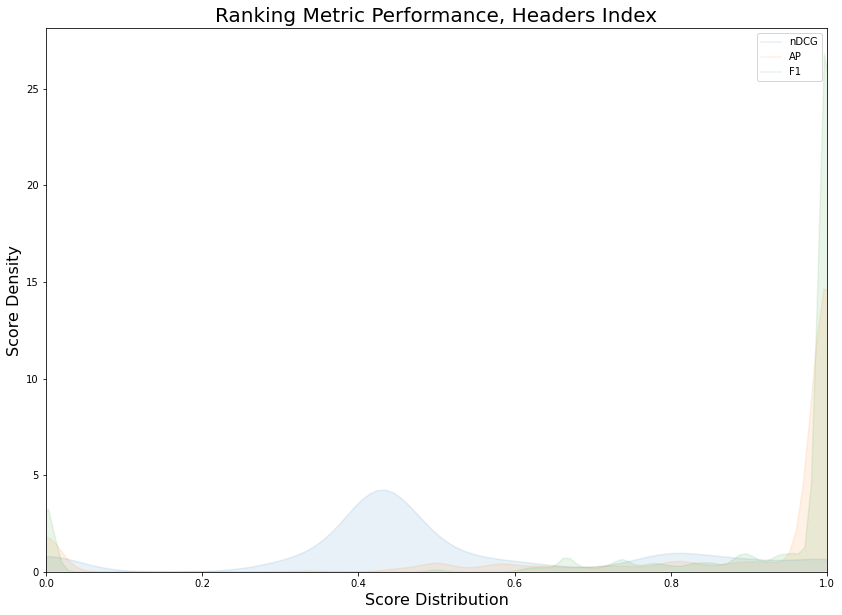

In [384]:
plt.figure(figsize = (14,10))

sns.kdeplot(Model_eval.nDCG, alpha=.1, shade=True, label='nDCG')
sns.kdeplot(Model_eval.AP, alpha=.1, shade=True,label='AP')
sns.kdeplot(Model_eval.F1,  alpha=.1, shade=True,label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Headers Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);

## Hybrid Scoring

In [385]:
CG = {}
DCG = {}
iDCG = {}
nDCG = {}
AP = {}
F_1 = {}
MAP = 0
count = 0
for (i,(k,j)) in zip(truth_dict.values(),hybrid_results_json.items()):
    CG[k] = Cummulative_gain(i,j)
    DCG[k] = Discounted_Cummulative_gain(i,j)
    iDCG[k] = Ideal_discounted_cummulative_gain(i,j)
    nDCG[k] = nDiscounted_Cummulative_gain(i,j)
    AP[k] = average_precision(i,j)
    F_1[k] = F_1_score(i,j)
    count += 1
    MAP += AP[k]
Model_eval2 = pd.DataFrame(data=[CG, DCG, iDCG, nDCG, AP, F_1])
MAP/count

0.6829245363866463

In [386]:
Model_eval2 = Model_eval2.transpose().rename({0:'CG',1:'DCG',2:'iDCG',3:'nDCG',4:'AP',5:'F1'}, axis=1)
Model_eval2

,CG,DCG,iDCG,nDCG,AP,F1
0002,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
0003,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
0004,1.0,0.386853,1.000000,0.386814,0.999900,0.999950
0005,1.0,0.333333,1.000000,0.333300,0.999900,0.999950
0006,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...
0465,4.0,2.394940,2.561606,0.934900,0.949976,0.974346
0466,1.0,1.000000,1.000000,0.999900,0.999900,0.999950
0467,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
0468,1.0,0.430677,1.000000,0.430633,0.499950,0.666622


In [387]:
Mean_scores2 = Model_eval2.mean()
Mean_scores2

CG      1.322650
DCG     0.731545
iDCG    1.116827
nDCG    0.518404
AP      0.682925
F1      0.729714
dtype: float64

In [388]:
mean_df = pd.DataFrame(data=[Mean_scores, Mean_scores2])
mean_df=mean_df.rename({0:'headers',1:'hybrid'},axis=0)
mean_df

,CG,DCG,iDCG,nDCG,AP,F1
headers,1.891026,0.878151,1.403936,0.507060,0.860629,0.880393
hybrid,1.322650,0.731545,1.116827,0.518404,0.682925,0.729714


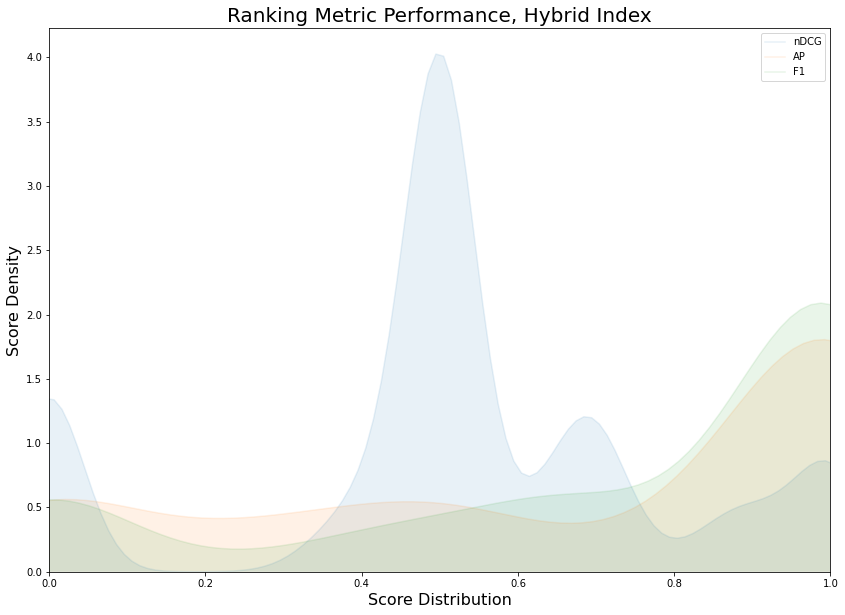

In [389]:
plt.figure(figsize = (14,10))

sns.kdeplot(Model_eval2.nDCG, alpha=.1, shade=True, label='nDCG')
sns.kdeplot(Model_eval2.AP, alpha=.1, shade=True, label='AP')
sns.kdeplot(Model_eval2.F1,  alpha=.1, shade=True, label='F1')
plt.legend()
plt.title('Ranking Metric Performance, Hybrid Index', fontsize=20)
plt.xlabel('Score Distribution', fontsize=16)
plt.ylabel('Score Density', fontsize=16)
plt.xlim(0,1);